Скачиваю данные

In [2]:
!unzip -q /content/drive/MyDrive/colab_data/porto-seguro-safe-driver-prediction -d data

replace data/__MACOSX/._porto-seguro-safe-driver-prediction? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [4]:
train_df = pd.read_csv(
    "/content/data/porto-seguro-safe-driver-prediction/train.csv",
    index_col="id",
)

test_df = pd.read_csv(
    "/content/data/porto-seguro-safe-driver-prediction/test.csv",
    index_col="id",
)

In [5]:
train_df.head()

,target,ps_ind_01,ps_ind_02_cat,ps_ind_03,ps_ind_04_cat,ps_ind_05_cat,ps_ind_06_bin,ps_ind_07_bin,ps_ind_08_bin,ps_ind_09_bin,...,ps_calc_11,ps_calc_12,ps_calc_13,ps_calc_14,ps_calc_15_bin,ps_calc_16_bin,ps_calc_17_bin,ps_calc_18_bin,ps_calc_19_bin,ps_calc_20_bin
id,,,,,,,,,,,,,,,,,,,,,
7,0,2,2,5,1,0,0,1,0,0,...,9,1,5,8,0,1,1,0,0,1
9,0,1,1,7,0,0,0,0,1,0,...,3,1,1,9,0,1,1,0,1,0
13,0,5,4,9,1,0,0,0,1,0,...,4,2,7,7,0,1,1,0,1,0
16,0,0,1,2,0,0,1,0,0,0,...,2,2,4,9,0,0,0,0,0,0
17,0,0,2,0,1,0,1,0,0,0,...,3,1,1,3,0,0,0,1,1,0


Что означают столбцы в датасете

- **`id`** — идентификатор
- **`target`** - целевая переменная

### Как читать имя признака
Формат: `ps_<group>_<nn>_<type>`

- **`group` (семейство признаков)**:
  - `ind` — индивидуальные характеристики
  - `reg` — регион/регистрация
  - `car` — автомобиль
  - `calc` — вычисленные/производные признаки
- **`nn`** — порядковый номер внутри группы.
- **`type` (суффикс)**:
  - `_bin` — бинарный признак
  - `_cat` — категориальный признак (целые коды категорий)
  - без суффикса — числовой (continuous или ordinal)

Общие данные по датасету, подготовка данных для анализа

In [6]:
TARGET = "target"
ID = "id"

df = train_df.copy()

feature_cols = [c for c in df.columns if c not in [ID, TARGET]]
cat_cols = [c for c in feature_cols if c.endswith("_cat")]
bin_cols = [c for c in feature_cols if c.endswith("_bin")]
num_cols = [c for c in feature_cols if c not in cat_cols + bin_cols]

print("Rows/Cols:", df.shape)
print("Target mean (claim rate):", df[TARGET].mean())
print("Features:", len(feature_cols), "| cat:", len(cat_cols), "| bin:", len(bin_cols), "| num:", len(num_cols))

Rows/Cols: (595212, 58)
Target mean (claim rate): 0.036447517859182946
Features: 57 | cat: 14 | bin: 17 | num: 26


Пропуски

,missing_rate,missing_cnt,nunique
ps_car_03_cat,0.690898,411231,3
ps_car_05_cat,0.447825,266551,3
ps_reg_03,0.181065,107772,5013
ps_car_14,0.071605,42620,850
ps_car_07_cat,0.019302,11489,3
ps_ind_05_cat,0.009760,5809,8
ps_car_09_cat,0.000956,569,6
ps_ind_02_cat,0.000363,216,5
ps_car_01_cat,0.000180,107,13
ps_ind_04_cat,0.000139,83,3


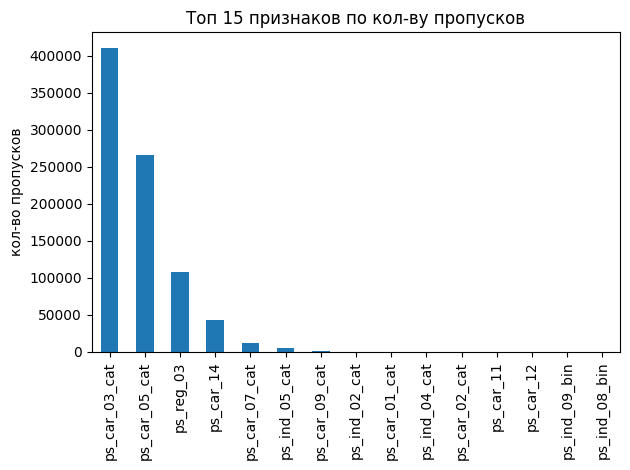

In [7]:
missing_rate = (df[feature_cols] == -1).mean().sort_values(ascending=False)
missing_cnt = (df[feature_cols] == -1).sum().sort_values(ascending=False)

miss = pd.DataFrame({
    "missing_rate": missing_rate,
    "missing_cnt": missing_cnt,
    "nunique": df[feature_cols].nunique(dropna=False)
})

display(miss.sort_values(by="missing_cnt", ascending=False).head(15))

plt.figure()
missing_cnt.head(15).plot(kind="bar")
plt.title("Топ 15 признаков по кол-ву пропусков")
plt.ylabel("кол-во пропусков")
plt.tight_layout()
plt.show()

In [8]:
cols_miss = miss.sort_values("missing_cnt", ascending=False).head(13).index.tolist()
cols_miss

['ps_car_03_cat',
 'ps_car_05_cat',
 'ps_reg_03',
 'ps_car_14',
 'ps_car_07_cat',
 'ps_ind_05_cat',
 'ps_car_09_cat',
 'ps_ind_02_cat',
 'ps_car_01_cat',
 'ps_ind_04_cat',
 'ps_car_11',
 'ps_car_02_cat',
 'ps_car_12']

In [9]:
cols_miss = miss.sort_values("missing_cnt", ascending=False).head(13).index.tolist()

# флаг пропусков
for c in cols_miss:
    df[c + "_is_missing"] = (df[c] == -1).astype(int)

Смотрим на разницу между долей единиц в строках с пропусками и без, заметив сильное различие diff можно сделать вывод о корреляции, то есть, например, если мы знаем что для признака n доля единиц на m процентов больше в полях с пропусками, чем в полях без пропусков, то тогда и модель будет обращать на это внимание при m умеренно или значительно больше 0

In [10]:
target = TARGET
for c in cols_miss:
    m = df[c + "_is_missing"].mean()
    p1 = df.loc[df[c + "_is_missing"]==1, target].mean()
    p0 = df.loc[df[c + "_is_missing"]==0, target].mean()
    print(c, "diff:", round(p1-p0,4))

ps_car_03_cat diff: -0.0121
ps_car_05_cat diff: -0.0086
ps_reg_03 diff: -0.0098
ps_car_14 diff: 0.0043
ps_car_07_cat diff: 0.0425
ps_ind_05_cat diff: 0.0473
ps_car_09_cat diff: 0.055
ps_ind_02_cat diff: 0.1488
ps_car_01_cat diff: 0.2814
ps_ind_04_cat diff: 0.3612
ps_car_11 diff: -0.0364
ps_car_02_cat diff: -0.0364
ps_car_12 diff: -0.0364


Видим большие сдвиги для бинарного таргета, особенно:

- ps_ind_02_cat diff: 0.1488
- ps_car_01_cat diff: 0.2814
- ps_ind_04_cat diff: 0.3612

Значит пропуски не случайны и будут влиять на поведение модели, тогда можно попробовать два варианта:

- Оставить как есть для деревянных моделей (тк они могут сплитить на условие "==-1"), добавить флаги

- Для линейных моделей изменить -1 на NaN, добавить флаги, заполнить пропуски



In [11]:
df_tree_train = train_df.copy()
for c in cols_miss:
    df_tree_train[c + "_is_missing"] = (df_tree_train[c] == -1).astype(np.int8)

In [12]:
df_tree_test = test_df.copy()
for c in cols_miss:
    df_tree_test[c + "_is_missing"] = (df_tree_test[c] == -1).astype(np.int8)

In [13]:
cat_cols = [c for c in cols_miss if c.endswith("_cat")]
bin_cols = [c for c in feature_cols if c.endswith("_bin")]
num_cols = [c for c in cols_miss if c not in cat_cols and c not in bin_cols]

In [14]:
df_linear = train_df.copy()

not_cat_cols = num_cols + bin_cols

for c in not_cat_cols:
    df_linear[c + "_is_missing"] = (df_linear[c] == -1).astype(np.int8) #тк для категориальных появятся после OHE

df_linear[cols_miss] = df_linear[cols_miss].replace(-1, np.nan)

df_linear[cat_cols] = df_linear[cat_cols].fillna("MISSING").astype(str) # для OHE

df_linear[num_cols] = df_linear[num_cols].fillna(df_linear[num_cols].median()) #для числовых попробуем заменить медианой

In [15]:
df_linear_test = test_df.copy()

not_cat_cols = num_cols + bin_cols

for c in not_cat_cols:
    df_linear_test[c + "_is_missing"] = (df_linear_test[c] == -1).astype(np.int8) #тк для категориальных появятся после OHE

df_linear_test[cols_miss] = df_linear_test[cols_miss].replace(-1, np.nan)

df_linear_test[cat_cols] = df_linear_test[cat_cols].fillna("MISSING").astype(str) # для OHE

df_linear_test[num_cols] = df_linear_test[num_cols].fillna(df_linear_test[num_cols].median()) #для числовых попробуем заменить медианой

Анализ выбросов

Для датасетов линейных моделей: bin - разница долей единиц таргета между группами 1 и 0, cat - количество и доля единиц для категории, для числовых outlier_rate по правилу IQR


BIN top diff:
              col      diff
9  ps_ind_17_bin  0.021285
4  ps_ind_10_bin  0.017613
6  ps_ind_12_bin  0.015137
7  ps_ind_13_bin  0.014985
1  ps_ind_07_bin  0.014674
0  ps_ind_06_bin -0.013048
8  ps_ind_16_bin -0.010996
5  ps_ind_11_bin  0.009248
2  ps_ind_08_bin  0.006655
3  ps_ind_09_bin -0.003973

CAT ps_car_11_cat top target-rate (count>=200):
                count      mean
ps_car_11_cat                 
41              3182  0.075110
18              1233  0.066504
75              1678  0.063170
58              1464  0.060792
4               1596  0.060777
63              1103  0.060743
97              1484  0.059299
93              2931  0.058683
21              2424  0.058581
72              2877  0.057004

NUM top outlier-rate:
 ps_calc_04    0.064019
ps_reg_02     0.061815
ps_reg_03     0.059666
ps_calc_12    0.059238
ps_car_14     0.051108
ps_car_15     0.046049
ps_car_13     0.045216
ps_car_11     0.043653
ps_calc_14    0.027026
ps_car_12     0.025798
dtype: floa

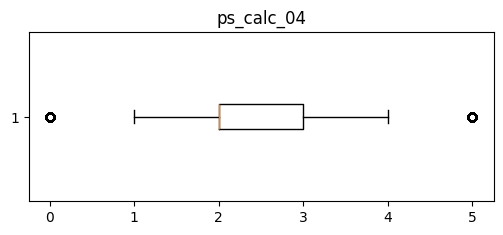

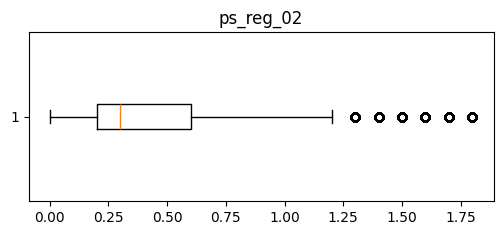

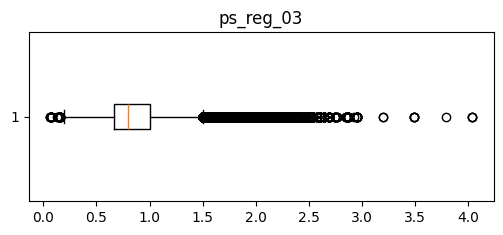

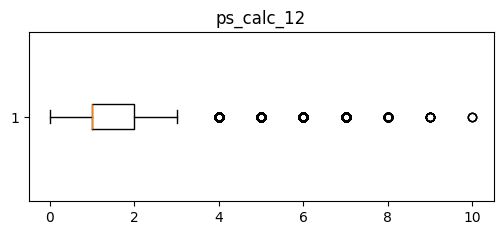

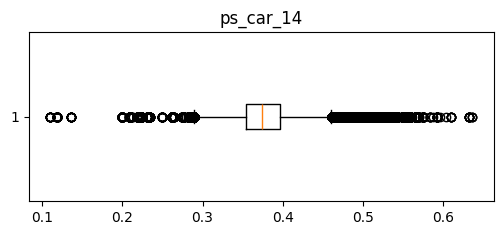

In [16]:
T=target
df=df_linear

bin_cols=[c for c in df.columns if c.endswith("_bin")]
cat_cols=[c for c in df.columns if c.endswith("_cat")]
mis_cols=[c for c in df.columns if c.endswith("_is_missing")]
num_cols=[c for c in df.select_dtypes(include=[np.number]).columns if c not in [T]+bin_cols+cat_cols+mis_cols]

# bin
b=pd.DataFrame({"col":bin_cols})
b["diff"]=[df.loc[df[c]==1,T].mean()-df.loc[df[c]==0,T].mean() for c in bin_cols]
print("\nBIN top diff:\n", b.reindex(b["diff"].abs().sort_values(ascending=False).head(10).index))

# cat
if cat_cols:
    c=max(cat_cols, key=lambda x: df[x].nunique())
    g=df.groupby(c)[T].agg(["count","mean"]).query("count>=200").sort_values("mean", ascending=False).head(10)
    print(f"\nCAT {c} top target-rate (count>=200):\n", g)

# num
def out_rate(s):
    q1,q3=s.quantile(.25),s.quantile(.75); iqr=q3-q1; lo,hi=q1-1.5*iqr,q3+1.5*iqr
    return ((s<lo)|(s>hi)).mean()

if num_cols:
    o=pd.Series({c:out_rate(df[c]) for c in num_cols}).sort_values(ascending=False)
    print("\nNUM top outlier-rate:\n", o.head(10))
    for c in o.head(5).index:
        plt.figure(figsize=(6,2.2)); plt.boxplot(df[c].dropna(), vert=False); plt.title(c); plt.show()

По outlier_rate (≈4–6% у топ-фич) видно, что сильных/экстремальных выбросов нет — это скорее обычные хвосты распределений.

-	Для df_linear (линейные модели): достаточно RobustScaler для числовых (он устойчив к хвостам и приводит масштабы)
-	Для df_tree (деревья/бустинг): не обрабатываем выбросы, деревья сами выбирают пороги

OneHotEncoder, RobustScaler

In [17]:

from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, RobustScaler
from sklearn.pipeline import Pipeline

In [18]:
target = TARGET

X = df_linear.drop(columns=[target])
y = df_linear[target]

cat_cols = X.select_dtypes(include=["object"]).columns.tolist()
num_cols = [c for c in X.columns if c not in cat_cols]

preprocess_ohe = ColumnTransformer(
    transformers=[
        ("cat", OneHotEncoder(handle_unknown="ignore", sparse_output=True, drop="if_binary"), cat_cols),
        ("num", RobustScaler(), num_cols),
    ],
    remainder="drop",
    sparse_threshold=0.3
)

X_ohe = preprocess_ohe.fit_transform(X)
feature_names = preprocess_ohe.get_feature_names_out()

if hasattr(X_ohe, "toarray"):
    X_ohe_df = pd.DataFrame(X_ohe.toarray(), columns=feature_names, index=df_linear.index) #если sparse после OHE
else:
    X_ohe_df = pd.DataFrame(X_ohe, columns=feature_names, index=df_linear.index)

df_linear_ohe = X_ohe_df.copy()
df_linear_ohe[target] = y.values

In [19]:
X = df_linear_test

X_ohe = preprocess_ohe.transform(X)
feature_names = preprocess_ohe.get_feature_names_out()

if hasattr(X_ohe, "toarray"):
    X_ohe_df = pd.DataFrame(X_ohe.toarray(), columns=feature_names, index=df_linear_test.index)
else:
    X_ohe_df = pd.DataFrame(X_ohe, columns=feature_names, index=df_linear_test.index)

df_linear_ohe_test = X_ohe_df.copy()

In [20]:
print("Rows:", X_ohe.shape[0])
print("Total features:", X_ohe.shape[1])

df_linear_ohe.head(5)

Rows: 892816
Total features: 116


,cat__ps_ind_02_cat_1.0,cat__ps_ind_02_cat_2.0,cat__ps_ind_02_cat_3.0,cat__ps_ind_02_cat_4.0,cat__ps_ind_02_cat_MISSING,cat__ps_ind_04_cat_0.0,cat__ps_ind_04_cat_1.0,cat__ps_ind_04_cat_MISSING,cat__ps_ind_05_cat_0.0,cat__ps_ind_05_cat_1.0,...,num__ps_ind_16_bin_is_missing,num__ps_ind_17_bin_is_missing,num__ps_ind_18_bin_is_missing,num__ps_calc_15_bin_is_missing,num__ps_calc_16_bin_is_missing,num__ps_calc_17_bin_is_missing,num__ps_calc_18_bin_is_missing,num__ps_calc_19_bin_is_missing,num__ps_calc_20_bin_is_missing,target
id,,,,,,,,,,,,,,,,,,,,,
7,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
9,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
13,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
16,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
17,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0


Фич мало, размерность можно не понижать

Коррреляция: тк данные анонимизированы и стандартизированы, то корреляция никак не поможет в интерпретации, единственное можно проверить на мультиколлинеарность для линейных

In [21]:
X = df_linear_ohe.drop(columns=[target])

C = X.corr().abs()
np.fill_diagonal(C.values, 0)

thr = 0.95
pairs = (C.where(C > thr).stack().sort_values(ascending=False))
pairs.head(30)

,,0
cat__ps_car_02_cat_1.0,cat__ps_car_02_cat_0.0,0.999970
cat__ps_car_02_cat_0.0,cat__ps_car_02_cat_1.0,0.999970
cat__ps_ind_04_cat_1.0,cat__ps_ind_04_cat_0.0,0.999713
cat__ps_ind_04_cat_0.0,cat__ps_ind_04_cat_1.0,0.999713


Похоже что в категориальные попал бинарный признак, хотя странно что drop="if_binary" не сработал, возможно из-за пропусков, чтоб не было мультиколлинеарности лучше удалить один из коррелирующих столбцов

In [22]:
df_linear_ohe = df_linear_ohe.drop(columns=["cat__ps_car_02_cat_1.0", "cat__ps_ind_04_cat_1.0"])

In [23]:
df_linear_ohe_test = df_linear_ohe_test.drop(columns=["cat__ps_car_02_cat_1.0", "cat__ps_ind_04_cat_1.0"])

In [24]:
X = df_linear_ohe.drop(columns=[target])

C = X.corr().abs()
np.fill_diagonal(C.values, 0)

thr = 0.95
pairs = (C.where(C > thr).stack().sort_values(ascending=False))
pairs.head(30)

,,0


In [25]:
df_linear_ohe_train = df_linear_ohe

Так как данные анонимизированы, то интерпретировать их не получится, следовательно, создать новые фичи тоже

Итого получили: df_linear_ohe_train, df_linear_ohe_test, df_tree_train, df_tree_test

Попробуем обучить 4 модели: log reg, log reg с регуляризацией, random forest, CatBoost

Метрика

In [26]:
from sklearn.metrics import roc_auc_score

def normalized_gini(y_true, y_score):
    return 2 * roc_auc_score(y_true, y_score) - 1

In [27]:
from sklearn.linear_model import LogisticRegression

TARGET = "target"

Xtr = df_linear_ohe_train.drop(columns=[TARGET])
ytr = df_linear_ohe_train[TARGET].values
Xte = df_linear_ohe_test[Xtr.columns]

# 1) без регуляризации
lr_none = LogisticRegression(penalty=None, solver="lbfgs", max_iter=2000, n_jobs=-1)
lr_none.fit(Xtr, ytr)
p_tr_lr_none = lr_none.predict_proba(Xtr)[:, 1]
p_te_lr_none = lr_none.predict_proba(Xte)[:, 1]

# 2) с L2 регуляризацией
lr_l2 = LogisticRegression(penalty="l2", C=0.1, solver="lbfgs", max_iter=2000, n_jobs=-1)
lr_l2.fit(Xtr, ytr)
p_tr_lr_l2 = lr_l2.predict_proba(Xtr)[:, 1]
p_te_lr_l2 = lr_l2.predict_proba(Xte)[:, 1]

print("GINI train (LR none):", normalized_gini(ytr, p_tr_lr_none))
print("GINI train (LR L2)  :", normalized_gini(ytr, p_tr_lr_l2))

GINI train (LR none): 0.2623467146715637
GINI train (LR L2)  : 0.26234002260657374


Кросс Валидация

In [28]:
from sklearn.model_selection import StratifiedKFold, GridSearchCV
from sklearn.metrics import roc_auc_score, make_scorer


X = df_linear_ohe_train.drop(columns=[TARGET])
y = df_linear_ohe_train[TARGET].values

def gini_metric(y_true, y_score):
    return 2 * roc_auc_score(y_true, y_score) - 1

gini_scorer = make_scorer(gini_metric, needs_proba=True)

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

lr = LogisticRegression(
    penalty="l2",
    solver="lbfgs",
    max_iter=1000
)

param_grid = {
    "C": [0.01, 0.03, 0.1, 0.3, 1.0, 3.0, 10.0],
    "class_weight": [None, "balanced"],
}

gs = GridSearchCV(
    lr,
    param_grid=param_grid,
    scoring=gini_scorer,
    cv=cv,
    n_jobs=-1,
    verbose=1,
)

gs.fit(X, y)

print("Best params:", gs.best_params_)
print("Best CV GINI:", gs.best_score_)

pd.DataFrame(gs.cv_results_)[
    ["mean_test_score","std_test_score","param_C","param_class_weight"]
].sort_values("mean_test_score", ascending=False).head(10)

Fitting 5 folds for each of 14 candidates, totalling 70 fits


/usr/local/lib/python3.12/dist-packages/sklearn/model_selection/_search.py:1108: UserWarning: One or more of the test scores are non-finite: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan]
  warnings.warn(


Best params: {'C': 0.01, 'class_weight': None}
Best CV GINI: nan


,mean_test_score,std_test_score,param_C,param_class_weight
0,NaN,NaN,0.01,None
1,NaN,NaN,0.01,balanced
2,NaN,NaN,0.03,None
3,NaN,NaN,0.03,balanced
4,NaN,NaN,0.10,None
5,NaN,NaN,0.10,balanced
6,NaN,NaN,0.30,None
7,NaN,NaN,0.30,balanced
8,NaN,NaN,1.00,None
9,NaN,NaN,1.00,balanced


In [29]:
from sklearn.linear_model import LogisticRegression

TARGET = "target"

Xtr = df_linear_ohe_train.drop(columns=[TARGET])
ytr = df_linear_ohe_train[TARGET].values
Xte = df_linear_ohe_test[Xtr.columns]

# 1) без регуляризации
lr_none = LogisticRegression(penalty=None, solver="lbfgs", max_iter=2000, n_jobs=-1)
lr_none.fit(Xtr, ytr)
p_tr_lr_none = lr_none.predict_proba(Xtr)[:, 1]
p_te_lr_none = lr_none.predict_proba(Xte)[:, 1]

# 2) L2 с лучшими параметрами из GridSearchCV (gs)
best_C = gs.best_params_["C"]
best_cw = gs.best_params_["class_weight"]

lr_l2 = LogisticRegression(
    penalty="l2",
    C=best_C,
    class_weight=best_cw,
    solver="lbfgs",
    max_iter=2000,
    n_jobs=-1
)
lr_l2.fit(Xtr, ytr)
p_tr_lr_l2 = lr_l2.predict_proba(Xtr)[:, 1]
p_te_lr_l2 = lr_l2.predict_proba(Xte)[:, 1]

print("Best params used for L2:", {"C": best_C, "class_weight": best_cw})
print("GINI train (LR none):", normalized_gini(ytr, p_tr_lr_none))
print("GINI train (LR L2)  :", normalized_gini(ytr, p_tr_lr_l2))

Best params used for L2: {'C': 0.01, 'class_weight': None}
GINI train (LR none): 0.2623467146715637
GINI train (LR L2)  : 0.2625241579953441


In [34]:
sample = pd.read_csv("/content/data/porto-seguro-safe-driver-prediction/sample_submission.csv")

pred = p_te_lr_l2

sample["target"] = pred
sample.to_csv("submission.csv", index=False)

sample.head()

,id,target
0,0,0.027598
1,1,0.032880
2,2,0.027100
3,3,0.017725
4,4,0.034029


RandomForest

In [32]:
from sklearn.ensemble import RandomForestClassifier

TARGET="target"
X = df_tree_train.drop(columns=[TARGET])
y = df_tree_train[TARGET].values
Xte = df_tree_test[X.columns]

rf = RandomForestClassifier(
    n_estimators=300,
    max_depth=12,
    min_samples_leaf=10,
    max_features="sqrt",
    n_jobs=-1,
    random_state=42
)

rf.fit(X, y)

p_tr_rf = rf.predict_proba(X)[:, 1]
p_te_rf = rf.predict_proba(Xte)[:, 1]

print("GINI train (RF):", normalized_gini(y, p_tr_rf))

GINI train (RF): 0.5345925032007162


In [38]:
sample = pd.read_csv("/content/data/porto-seguro-safe-driver-prediction/sample_submission.csv")

pred = p_te_rf

sample["target"] = pred
sample.to_csv("submission_rf.csv", index=False)

sample.head()

,id,target
0,0,0.026608
1,1,0.026766
2,2,0.032874
3,3,0.017491
4,4,0.034153


Попробуем обрезать деревья чтоб не попасть в переобучение, пока деревья показывают себя значительно лучше


In [33]:
rf_pruned = RandomForestClassifier(
    n_estimators=300,
    max_depth=8,          # меньше глубина
    min_samples_leaf=50,  # больше лист -> проще модель
    min_samples_split=100,
    max_features="sqrt",
    n_jobs=-1,
    random_state=42
)

rf_pruned.fit(X, y)

p_tr = rf_pruned.predict_proba(X)[:, 1]
p_te = rf_pruned.predict_proba(Xte)[:, 1]

print("GINI train (RF pruned):", normalized_gini(y, p_tr))

GINI train (RF pruned): 0.3113788043771799


In [40]:
sample = pd.read_csv("/content/data/porto-seguro-safe-driver-prediction/sample_submission.csv")

pred = p_te

sample["target"] = pred
sample.to_csv("submission_rf.csv", index=False)


In [ ]:
Метрика стала хуже, нужно смотреть что будет после сабмита

In [ ]:
!pip -q install catboost
from catboost import CatBoostClassifier, Pool

TARGET="target"
X = df_tree_train.drop(columns=[TARGET]).copy()
y = df_tree_train[TARGET].values
Xte = df_tree_test[X.columns].copy()

cat_cols = [c for c in X.columns if c.endswith("_cat")]
for c in cat_cols:
    X[c] = X[c].astype(str)
    Xte[c] = Xte[c].astype(str)

train_pool = Pool(X, y, cat_features=cat_cols)
test_pool  = Pool(Xte, cat_features=cat_cols)

cb = CatBoostClassifier(
    iterations=1000,
    depth=5,
    learning_rate=0.1,
    l2_leaf_reg=6,
    loss_function="Logloss",
    eval_metric="AUC",
    random_seed=42,
    verbose=200
)

cb.fit(train_pool)

p_tr_cb = cb.predict_proba(train_pool)[:, 1]
p_te_cb = cb.predict_proba(test_pool)[:, 1]

print("GINI train (CatBoost):", normalized_gini(y, p_tr_cb))

0:	total: 1.04s	remaining: 17m 21s
